# Family Income and Expenditure

### Predicting income class based on budget allocation

We first need to import the necessary packages.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

file_path = '..\\datasets\\'
raw_fies = pd.read_csv(file_path + 'family_income_and_expenditure.csv')
raw_fies.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


In [2]:
raw_fies.shape

(41544, 60)

Let's see what the Lorenz curve of the country looks like

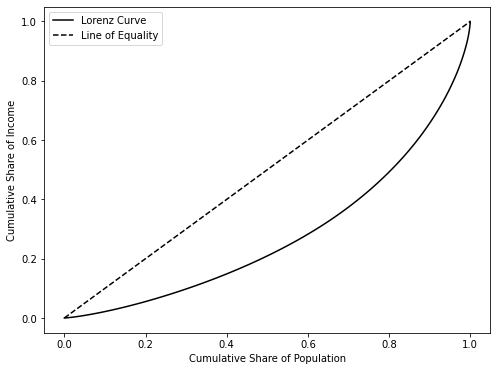

The Gini coefficient for this curve is 0.443841419057589


In [3]:
income = raw_fies['Total Household Income'].values
income_sorted = np.sort(income)
cumulative_income = np.cumsum(income_sorted)
lorenz_curve = cumulative_income / cumulative_income[-1]
lorenz_curve = np.insert(lorenz_curve, 0, 0)
x_values = np.linspace(0, 1, len(lorenz_curve))

plt.figure(figsize=(8, 6))
plt.plot(x_values, lorenz_curve, 'k', drawstyle='steps-post', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Line of Equality')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Income')
# plt.title('Lorenz Curve')
plt.legend()
plt.savefig('..//figures//LorenzCurve.png', bbox_inches = 'tight',dpi = 400)
plt.show()

gini_coefficient = 1 - 2 *  np.trapz(lorenz_curve, x_values) 
print('The Gini coefficient for this curve is {}'.format(gini_coefficient))

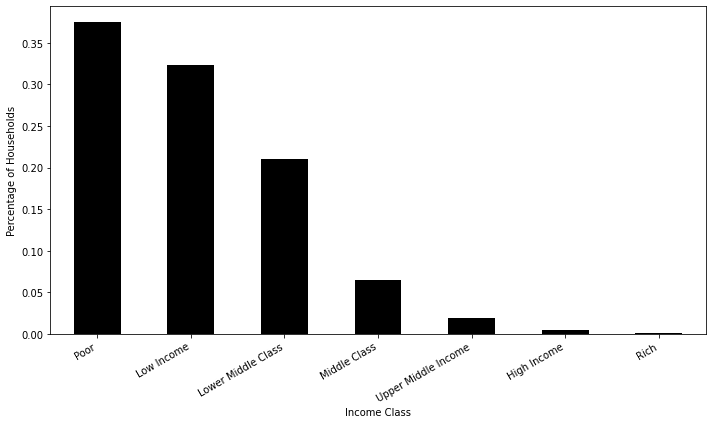

In [4]:
income_bins = [-float('inf'), 10957, 21194, 43828, 76669, 131484, 219140, float('inf')]
income_labels = ['Poor', 'Low Income', 'Lower Middle Class', 'Middle Class', 'Upper Middle Income', 'High Income', 'Rich']
raw_fies['Income Class'] = pd.cut(raw_fies['Total Household Income']/12, bins=income_bins, labels=income_labels, right=False)
raw_fies = raw_fies.drop(columns=['Total Household Income'])


plt.figure(figsize=(10, 6))
raw_fies['Income Class'].value_counts(sort=False, normalize= True).plot(kind='bar', color = 'black')
# plt.xlabel('Income Class')
plt.ylabel('Percentage of Households')
# plt.title('Distribution of Households by Income Class')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('..//figures//IncomeClass.png', dpi = 400, bbox_inches = 'tight')
plt.show()

In [5]:
target_col = 'Income Class'

#Extract the expenditure columns
exp_cols = [col for col in raw_fies.columns if 'Expenditure' in col or 'expense' in col]
tent_feat_cols = exp_cols
fies_tent = raw_fies[tent_feat_cols]

#Remove the redundant column
fies_tent = fies_tent.drop(columns= ['Total Food Expenditure'])
norm_fies = fies_tent.sum(axis = 1)
fies = 100*fies_tent.div(norm_fies, axis = 0)
fies.head()

,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses
0,13.256199,12.048231,7.762458,5.286751,1.045963,4.234182,0.943726,0.000000,0.000000,1.449248,20.018308,1.087487,1.502411,0.905977,11.387623,10.713173,2.264942,6.093322
1,9.324989,6.999796,9.381491,5.958544,1.095063,4.215052,1.269951,0.516590,1.147260,4.428684,22.261804,1.894164,6.941679,3.067254,15.766760,4.923749,0.807172,0.000000
2,29.294254,27.425119,6.670095,2.219651,1.482624,3.252346,3.895102,0.231392,3.877962,2.343917,12.289497,0.059991,0.277671,0.359943,0.364228,5.527703,0.428504,0.000000
3,23.391210,19.699344,7.501959,7.431847,0.474285,5.421289,4.316685,0.329938,0.000000,0.955445,11.436466,0.041242,4.701613,0.453664,0.206211,2.585887,0.343685,10.709229
4,18.509560,16.036126,9.776259,6.011620,0.741552,5.985573,3.402102,0.552842,0.000000,2.455892,16.543783,0.074421,3.718923,1.116315,0.000000,4.503532,0.531578,10.039922


C:\Users\PC\AppData\Local\Temp/ipykernel_5596/1670879503.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = full.groupby('Income Class')[fies.columns].mean()


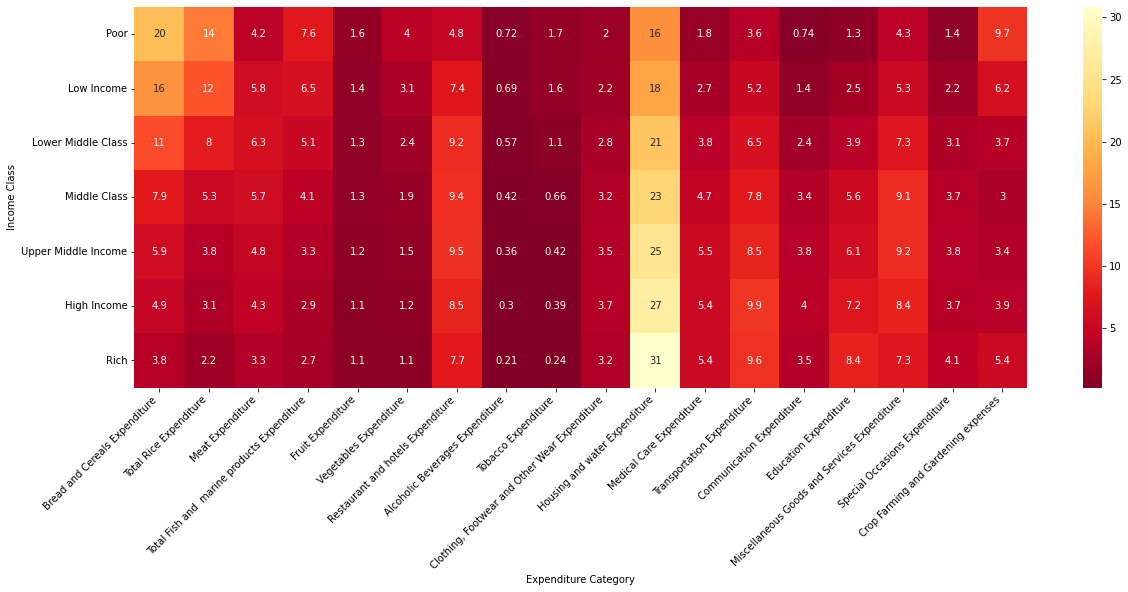

In [6]:
#Extract the expenditure columns
exp_cols = [col for col in raw_fies.columns if 'Expenditure' in col or 'expense' in col]
tent_feat_cols = exp_cols
fies_tent = raw_fies[tent_feat_cols]

#Remove the redundant column
fies_tent = fies_tent.drop(columns= ['Total Food Expenditure'])
norm_fies = fies_tent.sum(axis = 1)
fies = 100*fies_tent.div(norm_fies, axis = 0)

full = pd.DataFrame(raw_fies['Income Class']).join(fies)
grouped_df = full.groupby('Income Class')[fies.columns].mean()

plt.figure(figsize=(20, 7))
sns.heatmap(grouped_df, annot=True, cmap='YlOrRd_r')
plt.ylabel('Income Class')
plt.xlabel('Expenditure Category')
plt.xticks(rotation=45, ha='right')
plt.savefig('..//figures//ExpenditureAllocation.png', bbox_inches = 'tight', dpi = 400)
plt.show()

Get the numerical columns and categorical columns with low cardinality (unique values is less than 20).

In [7]:
num_cols = [col for col in fies.columns if fies[col].dtype in ['int64','flt64', 'float64']]
cat_cols = [col for col in fies.columns if fies[col].dtype in ['object', 'category'] and fies[col].nunique() < 20]
total_cols = num_cols + cat_cols

Are there null columns?

In [8]:
null = [col for col in total_cols if fies[col].isnull().any()]
print(null)

[]


In [9]:
target_fies = raw_fies[target_col]
feat_fies = raw_fies[total_cols]

x_train, x_test, y_train, y_test = train_test_split(feat_fies, target_fies, train_size = 0.8, random_state = 0)

In [10]:
num_transformer = SimpleImputer(strategy = 'median')
cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'constant')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocess = ColumnTransformer(transformers = [('num', num_transformer, num_cols), ('cat', cat_transformer, cat_cols)])

In [11]:
forest_model = RandomForestClassifier(random_state=0)

max_leaf_nodes = [node_val for node_val in range(1, 900, 1)]
max_depth = [depth for depth in range(1, 300, 1)]

random_grid = {'max_leaf_nodes': max_leaf_nodes, 'max_depth': max_depth}
n_estimators = [estim for estim in range(1, 100, 1)]

model_random = RandomizedSearchCV(
    estimator=forest_model,
    param_distributions={**random_grid, 'n_estimators': n_estimators},
    n_iter=30, cv=3, verbose=3, random_state=0, n_jobs=-1
)

pipeline = Pipeline(steps = [('preprocessor', preprocess), ('model', model_random)])
pipeline.fit(x_train, y_train.values.ravel())

opt_estim = model_random.best_params_['n_estimators']
opt_nodes = model_random.best_params_['max_leaf_nodes']
opt_depth = model_random.best_params_['max_depth']

print('The optimal n_estimator is: {}'.format(opt_estim))
print('The optimal max_leaf_nodes is: {}'.format(opt_nodes))
print('The optimal max_depth is: {}'.format(opt_depth))
print('The best score for the training data given the optimum parameters is {:.2f}%'.format(100 * model_random.best_score_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
The optimal n_estimator is: 99
The optimal max_leaf_nodes is: 747
The optimal max_depth is: 32
The best score for the training data given the optimum parameters is 74.60%


In [12]:
final_model = RandomForestClassifier(random_state=0, n_estimators=opt_estim, max_leaf_nodes=opt_nodes, max_depth=opt_depth)
pipeline = Pipeline(steps = [('preprocessor', preprocess), ('model', final_model)])
pipeline.fit(x_train, y_train.values.ravel())
y_predict = pipeline.predict(x_test)

correct = np.array(y_test == y_predict).sum()/y_test.count()
print('The accuracy of income class prediction for spending habits is {:.2f}%'.format(correct*100))

The accuracy of income class prediction for spending habits is 74.39%


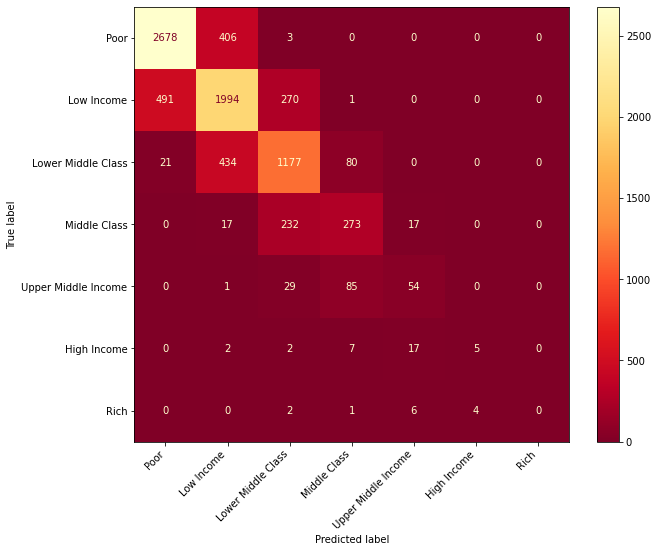

In [13]:
conf_matrix = confusion_matrix(y_test, y_predict, labels=income_labels)

# Create a figure and a set of subplots with the desired size
fig, ax = plt.subplots(figsize=(10, 8))

# Display the confusion matrix on the created axis
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=income_labels)
disp.plot(cmap='YlOrRd_r', ax=ax)

# Adjust the x-tick labels
plt.xticks(rotation=45, ha='right')
plt.savefig('..//figures//ConfusionMatrix.png', dpi = 400, bbox_inches = 'tight')

# Show the plot
plt.show()

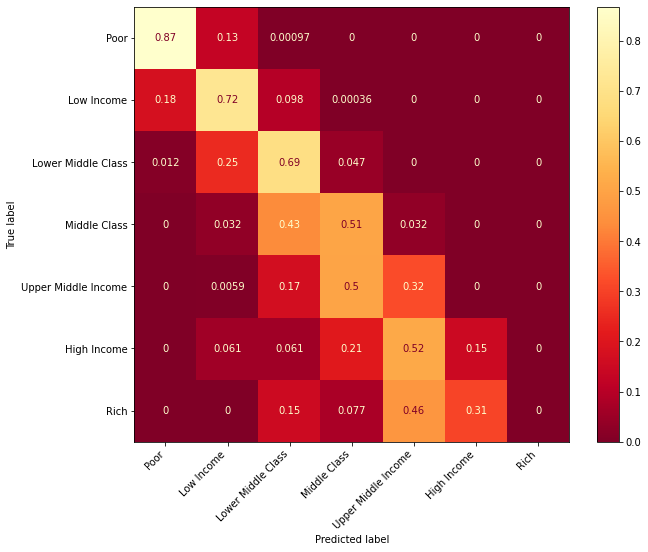

In [14]:
conf_matrix = confusion_matrix(y_test, y_predict, labels=income_labels, normalize='true')

# Create a figure and a set of subplots with the desired size
fig, ax = plt.subplots(figsize=(10, 8))

# Display the confusion matrix on the created axis
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=income_labels)
disp.plot(cmap='YlOrRd_r', ax=ax)

# Adjust the x-tick labels
plt.xticks(rotation=45, ha='right')
plt.savefig('..//figures//ConfusionMatrixNorm.png', dpi = 400, bbox_inches = 'tight')

# Show the plot
plt.show()